In [246]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.misc import derivative
import sympy as sp

# The Laplace Approximation


This example originates from the book Pattern Recognition and Machine Learning by Christopher M. Bishop. The main idea is to approximation a given probability distribution by a Gaussian distribution. The example is taken from section 4.4.


In [247]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

This is the distribution that we want to approximate with a Gaussian distribution


In [248]:
def f(z):
    return np.exp(-(z**2) / 2) * sigmoid(20 * z + 4)

We use numeric integration to compute the normalization factor Z. The function f is for all practical purposes 0 outside the interval [-10, 10].


In [249]:
Z, err = quad(f, -10, 10)
Z, err

(1.451189367558708, 1.0665858670360706e-08)

Normalized PDF


In [250]:
def p(z):
    return f(z) / Z

In [251]:
def log_f(z):
    return -1 * np.log(f(z))

Text(0.5, 1.0, 'log(f)')

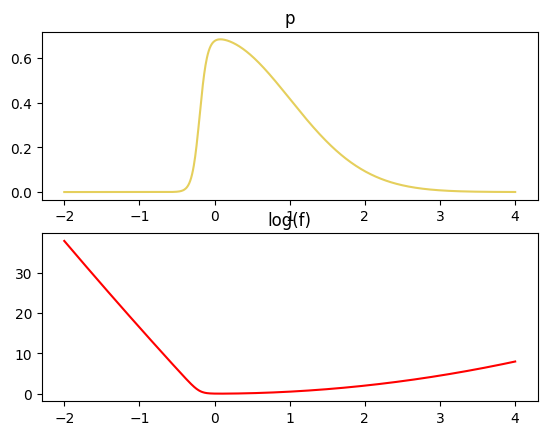

In [252]:
x = np.linspace(-2, 4, 1000)
px = p(x)
logfx = log_f(x)
fig, ax = plt.subplots(2)
ax[0].yaxis.set_ticks(np.arange(0, 1, 0.2))
ax[0].plot(x, px, color="#e5cf5c")
ax[0].set_title("p")
ax[1].plot(x, logfx, color="red")
ax[1].set_title("log(f)")

We need to find the mode of $p$ and the second derivate of $-\log(f)$. In this case the maximum of $p$ corresponds the minimum of $-\log(f)$. So we use Scipy to calculate not only the $z_0$ where the minimum of $p$ is obtained but also the Hessian (second derivate) in that point.


In [253]:
z_guess = 1.0
solution = minimize(log_f, z_guess, method="BFGS")
z_0 = solution.x
hessian = np.linalg.inv(solution.hess_inv)
z_0, hessian

(array([0.07747959]), array([[2.54881716]]))

The mean of the Gaussian approximation is $z_0$ and variance is $1/hessian$.

In [255]:
# x = np.linspace(-2, 4, 1000)
# px = p(x)
# gaussian =  norm.pdf(x, z_0[0], np.sqrt(1 / hessian[0][0]))

In [258]:
x = np.linspace(-2, 4, 1000)
fx = f(x)
q = lambda x: f(z_0[0]) * np.exp(-hessian[0][0] / 2 * (x - z_0[0]) ** 2)
qx = q(x)

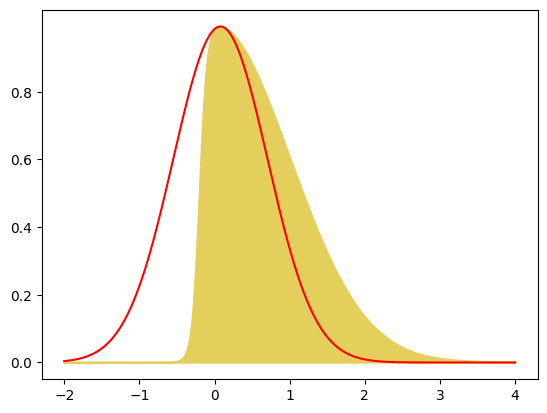

In [260]:
fig, ax = plt.subplots()
ax.yaxis.set_ticks(np.arange(0, 1, 0.2))
ax.fill_between(x, 0, fx, color="#e5cf5c")
ax.plot(x, fx, color="#e5cf5c")
ax.plot(x, qx, color="red");

## How to determine the normalization constant Z

Using equation 4.135 from the Pattern Recognition book:

In [198]:
Z1 = f(z_0[0]) * np.sqrt(2 * np.pi) / np.sqrt(hessian[0][0])
Z1

1.5543007921128233

Scipy derivative calculation:

In [199]:
d = derivative(log_f, z_0[0], dx=1e-6, n=2)
d

C:\Users\carsten.jorgensen\AppData\Local\Temp\ipykernel_20892\406683536.py:1: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  d = derivative(log_f, z_0[0], dx=1e-6, n=2)


2.5437603412559184

Using sympy

In [200]:
x = sp.symbols("x")

f_s = sp.log(sp.exp(-(x**2) / 2) / (1.0 + sp.exp(-(20 * x + 4))))

df = sp.diff(f_s, x)
df2 = sp.diff(df, x)
print(df2)

x*(-x*exp(-x**2/2)/(exp(-20*x - 4) + 1.0) + 20*exp(-x**2/2)*exp(-20*x - 4)/(exp(-20*x - 4) + 1.0)**2)*(exp(-20*x - 4) + 1.0)*exp(x**2/2) - 20*(-x*exp(-x**2/2)/(exp(-20*x - 4) + 1.0) + 20*exp(-x**2/2)*exp(-20*x - 4)/(exp(-20*x - 4) + 1.0)**2)*exp(x**2/2)*exp(-20*x - 4) + (exp(-20*x - 4) + 1.0)*(x**2*exp(-x**2/2)/(exp(-20*x - 4) + 1.0) - 40*x*exp(-x**2/2)*exp(-20*x - 4)/(exp(-20*x - 4) + 1.0)**2 - exp(-x**2/2)/(exp(-20*x - 4) + 1.0) - 400*exp(-x**2/2)*exp(-20*x - 4)/(exp(-20*x - 4) + 1.0)**2 + 800*exp(-x**2/2)*exp(-40*x - 8)/(exp(-20*x - 4) + 1.0)**3)*exp(x**2/2)


In [201]:
df = (
    lambda x: x
    * (
        -x * np.exp(-(x**2) / 2) / (np.exp(-20 * x - 4) + 1.0)
        + 20
        * np.exp(-(x**2) / 2)
        * np.exp(-20 * x - 4)
        / (np.exp(-20 * x - 4) + 1.0) ** 2
    )
    * (np.exp(-20 * x - 4) + 1.0)
    * np.exp(x**2 / 2)
    - 20
    * (
        -x * np.exp(-(x**2) / 2) / (np.exp(-20 * x - 4) + 1.0)
        + 20
        * np.exp(-(x**2) / 2)
        * np.exp(-20 * x - 4)
        / (np.exp(-20 * x - 4) + 1.0) ** 2
    )
    * np.exp(x**2 / 2)
    * np.exp(-20 * x - 4)
    + (np.exp(-20 * x - 4) + 1.0)
    * (
        x**2 * np.exp(-(x**2) / 2) / (np.exp(-20 * x - 4) + 1.0)
        - 40
        * x
        * np.exp(-(x**2) / 2)
        * np.exp(-20 * x - 4)
        / (np.exp(-20 * x - 4) + 1.0) ** 2
        - np.exp(-(x**2) / 2) / (np.exp(-20 * x - 4) + 1.0)
        - 400
        * np.exp(-(x**2) / 2)
        * np.exp(-20 * x - 4)
        / (np.exp(-20 * x - 4) + 1.0) ** 2
        + 800
        * np.exp(-(x**2) / 2)
        * np.exp(-40 * x - 8)
        / (np.exp(-20 * x - 4) + 1.0) ** 3
    )
    * np.exp(x**2 / 2)
)

In [202]:
Z3 = f(z_0[0]) * np.sqrt(2 * np.pi) / np.sqrt(-df(z_0[0]))
Z3   

1.5609158783886565